# Pytorch MNIST

- Original source : https://github.com/jiuntian/pytorch-mnist-example/blob/master/pytorch-mnist.ipynb
- Modified by : JPark, Oct. 2022


In [120]:
import torch
import torchvision

In [121]:
# 디렉토리 없으면 만들기
import os
def makedir(path): 
    try: 
        os.makedirs(path)
    except OSError: 
        if not os.path.isdir(path): 
            raise
    return os.path.abspath(path)


In [122]:
## Create dataloader, in PyTorch, we feed the trainer data with use of dataloader
## We create dataloader with dataset from torchvision, 
## and we dont have to download it seperately, all automatically done

# Define batch size, batch size is how much data you feed for training in one iteration
batch_size_train = 64 # We use a small batch size here for training
batch_size_test = 1024 #

# define how image transformed
image_transform = torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])
#image datasets
train_dataset = torchvision.datasets.MNIST('dataset/', 
                                           train=True, 
                                           download=True,
                                           transform=image_transform)
test_dataset = torchvision.datasets.MNIST('dataset/', 
                                          train=False, 
                                          download=True,
                                          transform=image_transform)
#data loaders
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size_train, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size_test, 
                                          shuffle=True)

In [123]:
# debugging code for grid plotting
import numpy as np
idxes = np.array( [0,1,2,3, 4,5,6,7, 8,9,10,11] )
print( idxes//4 )
print( idxes%6 )

[0 0 0 0 1 1 1 1 2 2 2 2]
[0 1 2 3 4 5 0 1 2 3 4 5]


In [124]:
axes[1][1]

<AxesSubplot:title={'center':'Label = 2'}>

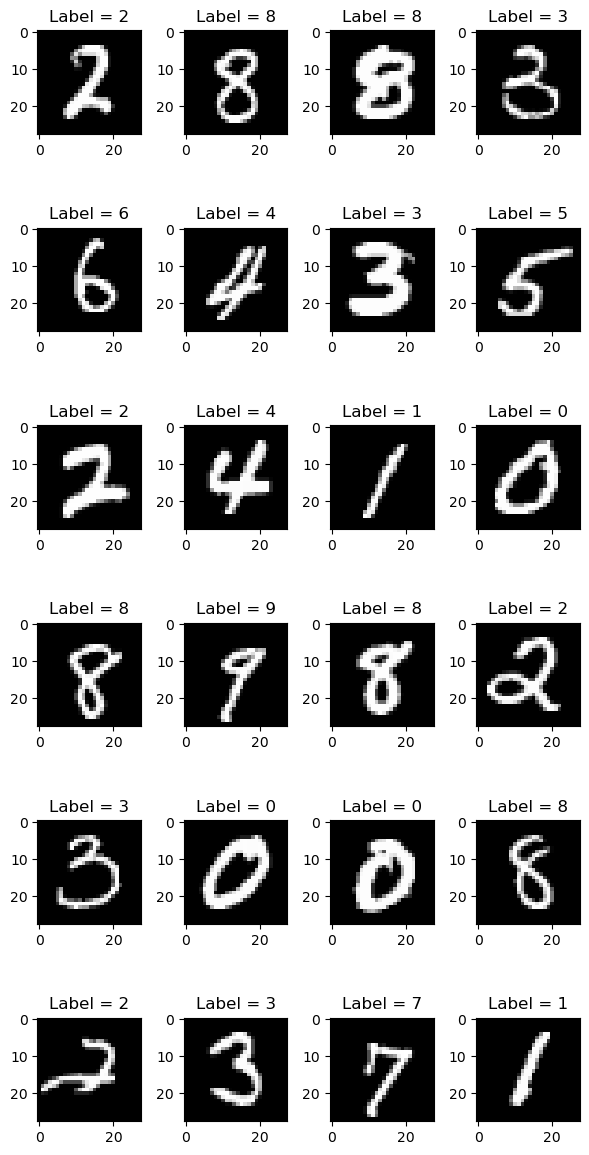

In [125]:
# import library
import matplotlib.pyplot as plt
# We can check the dataloader
_, (example_datas, labels) = next(enumerate(test_loader))

rows = 6
cols = 4
N = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(1.5*cols, 2*rows))
for idx in range(N):
    img = example_datas[idx][0]
    ax = axes[idx//cols][idx%cols]
    ax.imshow(img, cmap='gray', interpolation='none')
    ax.set_title( f'Label = {labels[idx]}' )
    
plt.tight_layout()
plt.show()
    

In [142]:
## Now we can start to build our CNN model
## We first import the pytorch nn module and optimizer
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## Then define the model class
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        #input channel 1, output channel 10
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5, stride=1)
        
        #input channel 10, output channel 20
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5, stride=1)
        
        #dropout layer
        self.conv2_drop = nn.Dropout2d()
        
        #fully connected layer
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        
        x = self.conv2(x)
        x = self.conv2_drop(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        
        x = x.view(-1, 320)
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x)
        x = self.fc2(x)
        
        return F.log_softmax(x)

In [157]:
## create model and optimizer
learning_rate = 0.01
momentum = 0.5

device = 'cpu'
model = CNN().to(device) #using cpu here
optimizer = optim.SGD(model.parameters(), 
                      lr=learning_rate,
                      momentum=momentum)

In [158]:
from tqdm.notebook import tqdm

##define train function
def train(model, device, train_loader, optimizer, epoch, log_interval=10000):
    model.train()
    tk0 = tqdm(train_loader, total=int(len(train_loader)))
    counter = 0
    for batch_idx, (data, target) in enumerate(tk0):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        counter += 1
        tk0.set_postfix(loss=(loss.item()*data.size(0) / (counter * train_loader.batch_size)))

##define test function
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [165]:
# Training
epochs = 10
for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch)


  0%|          | 0/938 [00:00<?, ?it/s]

/var/folders/pv/78hsfpv1623068f45h32ygw80000gn/T/ipykernel_98347/58221827.py:41: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

In [166]:
model

CNN(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [167]:
dirpath = makedir('checkpoint')
fpath_model = f'{dirpath}/mnist_torch_cnn_epoch{epochs}.pt'
torch.save(model, fpath_model)

In [168]:
device = 'cpu'
from torchsummary import summary
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 24, 24]             260
            Conv2d-2             [-1, 20, 8, 8]           5,020
         Dropout2d-3             [-1, 20, 8, 8]               0
            Linear-4                   [-1, 50]          16,050
            Linear-5                   [-1, 10]             510
Total params: 21,840
Trainable params: 21,840
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.08
Estimated Total Size (MB): 0.15
----------------------------------------------------------------


/var/folders/pv/78hsfpv1623068f45h32ygw80000gn/T/ipykernel_98347/58221827.py:41: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [171]:
model4inference = torch.load(fpath_model)
model4inference.eval()
test(model4inference, device, test_loader)

/var/folders/pv/78hsfpv1623068f45h32ygw80000gn/T/ipykernel_98347/58221827.py:41: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Average loss: 0.0902, Accuracy: 9746/10000 (97%)



In [ ]:

##define test function
def test_one(model, device, img):
    model.eval()
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [178]:
img_rand = torch.rand((1, 1, 28, 28))
model(img_rand)

/var/folders/pv/78hsfpv1623068f45h32ygw80000gn/T/ipykernel_98347/58221827.py:41: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


tensor([[-2.0635, -2.1256, -2.6735, -2.7027, -2.2291, -2.4040, -2.0634, -2.3878,
         -2.2022, -2.4057]], grad_fn=<LogSoftmaxBackward0>)

In [186]:
_, (example_datas, labels) = next(enumerate(test_loader))
example_datas[0:1].shape

torch.Size([1, 1, 28, 28])

In [197]:
_, (example_datas, labels) = next(enumerate(test_loader))

idx = 6
img = example_datas[idx]
gt_label = labels[idx]
out = model(img)
pred_label = out.argmax(dim=1, keepdim=True) # get the index of the max log-probability

gt_label, pred_label

/var/folders/pv/78hsfpv1623068f45h32ygw80000gn/T/ipykernel_98347/58221827.py:41: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


(tensor(9), tensor([[9]]))